In [34]:
import requests
from pprint import pprint
from PIL import Image
import os
import shutil
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

In [10]:
img = cv2.imread('c:/Users/ax/retina-unet-master-disc/DRIVE/test/images/0404_test.tif')

In [17]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0]) #cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

#cv2.imshow('Color input image', img)
cv2.imshow('Histogram equalized', img_output)

cv2.waitKey(0)


27

In [18]:
cv2.destroyAllWindows()

In [20]:
temp_image_path = 'd:/Dane/test_out/temp_image.tif'

In [21]:
def process_image(input_path):
    img = cv2.imread(input_path)
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0]) #cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    cv2.imwrite(temp_image_path, img_output) 
    
    with open(temp_image_path, 'rb') as f:
        r = requests.post('http://127.0.0.1:5000/api/v1/segmentation/opticdisk', files = {'file': ('0792_test.tif', f, 'image/tiff', {'Expires': '0'})})
        print(r)    
        if r.status_code != 200:
            raise ValueError("Unexpected result")
            
        outputFileName = r.content
        return outputFileName

In [22]:
def read_gif_by_cv2(pathIn):
    cap = cv2.VideoCapture(pathIn)
    ret, image = cap.read()
    cap.release()
    return image

In [23]:
def compare_images(pathA, pathB):
    imA = Image.open(pathA)
    pixA = imA.load()
    
    imB = Image.open(pathB)
    pixB = imB.load()

    if imA.size != imB.size:
        print(imA.size)
        print(imB.size)
        raise ValueError("Images have different size")
        
    all_count = 0
    equal_count = 0
    false_white = 0
    false_black = 0
    
    for x in range(0, imA.size[0]):
        for y in range(0, imA.size[1]):
            all_count = all_count + 1
            
            pixelA = pixA[x,y]
            pixelB = pixB[x,y]
            
            valA = pixelA
            
            if pixelB < 100:
                valB = 0
            else:
                valB = 1
                
            if valA == valB:
                equal_count = equal_count + 1
                
            if valA == 0 and valB == 1:
                false_white = false_white + 1
                
            if valA == 1 and valB == 0:
                false_black = false_black + 1
                
    return (equal_count, all_count, all_count - equal_count, false_white, false_black, equal_count / all_count, (all_count - equal_count) / all_count)
    

In [24]:
def compare_images_cv2(cv2image1, cv2image2):
    
    rows1,cols1,_ = cv2image1.shape
    rows2,cols2,_ = cv2image2.shape
    
    if rows1 != rows2 or cols1 != cols2:
        print(rows1)
        print(rows2)
        print(cols1)
        print(cols2)
        raise ValueError("Images have different size")
        
    all_count = 0
    equal_count = 0
    false_white = 0
    false_black = 0
    
    for x in range(0, cols1):
        for y in range(0, rows1):
            all_count = all_count + 1
            
            pixelA = cv2image1[y,x].astype(int)
            pixelB = cv2image2[y,x].astype(int)
            
            valA = (pixelA[0] + pixelA[1] + pixelA[2]) / 3
            valB = (pixelB[0] + pixelB[1] + pixelB[2]) / 3
            
            if valA == valB:
                equal_count = equal_count + 1
                
            if valA == 0 and valB == 255:
                false_white = false_white + 1
                
            if valA == 255 and valB == 0:
                false_black = false_black + 1
                
            if valA != 0 and valA != 255:
                raise ValueError(str(valA) + ' ' + str(pixelA))
                
            if valB != 0 and valB != 255:
                raise ValueError(str(valB) + ' ' + str(pixelB))
                
    return (equal_count, all_count, all_count - equal_count, false_white, false_black, equal_count / all_count, (all_count - equal_count) / all_count)

In [39]:
def dump_to_pickle(obj, target_path):
    target_file = open(target_path, 'wb')
    pickle.dump(obj, target_file)
    target_file.close()

In [25]:
def compare_images_cv2_fast(cv2image1, cv2image2):
    
    rows1,cols1,_ = cv2image1.shape
    rows2,cols2,_ = cv2image2.shape
    
    if rows1 != rows2 or cols1 != cols2:
        print(rows1)
        print(rows2)
        print(cols1)
        print(cols2)
        raise ValueError("Images have different size")
        
    cv2image1int = cv2image1.astype(int)
    cv2image2int = cv2image2.astype(int)
    
    all_count = cv2image1int.shape[0] * cv2image1int.shape[1]
    diff = (cv2image1int - cv2image2int)
    diff = np.abs(diff)
    diff_sum = diff.sum() / (255 * cv2image1int.shape[2])
    equal_count = (np.sign((exp_img.astype(int) - img_out.astype(int))) == 0).astype(int).sum() / cv2image1int.shape[2]
    
    return (equal_count, diff_sum, all_count, equal_count + diff_sum)
    

In [26]:
input_dir = 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/'
expected_result_dir = 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/'

In [27]:
output_dir = 'd:/Dane/test_out/'

In [30]:
files = os.listdir(input_dir)
res_map = {}
for file_name in files:
    expected_result_file = file_name
    full_file_name = input_dir + file_name
    expected_result_file = expected_result_file.replace('_training.tif', '_manual1.gif')
    full_expected_result_file = expected_result_dir + expected_result_file
    output_file = process_image(full_file_name)
    res_map[file_name] = (full_file_name, output_file, full_expected_result_file)
    print(res_map[file_name])

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0001_training.tif', b'd:/Fundus/uploads\\6f21de98-40da-4f56-b811-317c54a58aee.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0001_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0002_training.tif', b'd:/Fundus/uploads\\ffee3689-50a4-40df-9dea-0a1449d9db7e.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0002_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0003_training.tif', b'd:/Fundus/uploads\\461e1d15-e85a-4c85-bb82-49b1398156a3.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0003_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0004_training.tif', b'd:/Fundus/uploads\\88f1c395-05ea-4d73-920c-8d1263dac852.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0033_training.tif', b'd:/Fundus/uploads\\bc68b0cf-9646-43ed-b725-b9fcb513b2a0.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0033_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0034_training.tif', b'd:/Fundus/uploads\\b8af901a-899d-49f5-bc98-8a1fa3136cc5.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0034_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0035_training.tif', b'd:/Fundus/uploads\\c0f91170-e8d8-4b4e-ab41-1f80da8f2d82.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0035_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0036_training.tif', b'd:/Fundus/uploads\\eb9d732e-d56b-4125-b8e6-ef680148fdc6.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0065_training.tif', b'd:/Fundus/uploads\\934db741-1f0d-4139-a59a-9799680ae0aa.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0065_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0066_training.tif', b'd:/Fundus/uploads\\3614dba7-0794-421e-a948-3a6e8691682d.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0066_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0067_training.tif', b'd:/Fundus/uploads\\9af50dce-8e92-48c5-b58b-074cd2835a27.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0067_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0068_training.tif', b'd:/Fundus/uploads\\bf613954-2394-46fa-b5e9-b448979977cb.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0097_training.tif', b'd:/Fundus/uploads\\d601498d-f2fc-4d18-b090-5c722f3519e9.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0097_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0098_training.tif', b'd:/Fundus/uploads\\3f924c3b-b8aa-4ef7-9bd0-3b95ed0f05ac.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0098_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0099_training.tif', b'd:/Fundus/uploads\\cb88176d-72d8-4d19-a07c-cccb8cb068e5.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0099_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0100_training.tif', b'd:/Fundus/uploads\\edbd31eb-d433-4951-a07f-d960d7ab6f95.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0129_training.tif', b'd:/Fundus/uploads\\eaf775f6-734f-4677-805e-0fd45e744ba8.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0129_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0130_training.tif', b'd:/Fundus/uploads\\7756f096-0690-4a61-b46e-cd740f656036.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0130_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0131_training.tif', b'd:/Fundus/uploads\\af4c00e8-d6b4-4a81-83da-1317ee1030b8.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0131_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0132_training.tif', b'd:/Fundus/uploads\\0e2d271a-57cc-4a1a-9514-ae87d92ae707.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0161_training.tif', b'd:/Fundus/uploads\\2c3502e5-177b-4708-8da8-68907b910eff.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0161_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0162_training.tif', b'd:/Fundus/uploads\\1a50acfe-4e62-435a-aaf5-c8811353bdfa.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0162_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0163_training.tif', b'd:/Fundus/uploads\\7edb10ab-fa3d-4467-a5df-24757753e4f3.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0163_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0164_training.tif', b'd:/Fundus/uploads\\f7970ed9-5cef-4d6e-b221-62e1d956f0f6.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0193_training.tif', b'd:/Fundus/uploads\\610c85d5-6d4a-4bc2-9297-b5d3faa4f980.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0193_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0194_training.tif', b'd:/Fundus/uploads\\ee5fec57-2e7b-4c4b-97c7-f4803411cea2.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0194_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0195_training.tif', b'd:/Fundus/uploads\\fd7d3033-cf8f-42cb-9ddd-33bee7aa92e9.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0195_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0196_training.tif', b'd:/Fundus/uploads\\64ee4783-3a01-4e1a-b2e6-c5470ed3aae3.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0225_training.tif', b'd:/Fundus/uploads\\eaca7efc-af81-4ee0-8701-42744b064afa.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0225_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0226_training.tif', b'd:/Fundus/uploads\\61d8ef9c-99bf-4d2b-8ad6-9b6044d3064d.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0226_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0227_training.tif', b'd:/Fundus/uploads\\d8b2d2f5-e770-491a-b4ec-4d4b0eab2a48.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0227_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0228_training.tif', b'd:/Fundus/uploads\\b8bb124c-7ad8-4ba1-8c5e-5a29f1c3f75d.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0257_training.tif', b'd:/Fundus/uploads\\540bdc7b-f648-49a1-bc91-05aa63029699.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0257_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0258_training.tif', b'd:/Fundus/uploads\\e9fff868-5ebd-4402-9eed-c0209ff65ecb.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0258_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0259_training.tif', b'd:/Fundus/uploads\\25e974d1-37bb-423b-ad87-abeb36b76bb6.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0259_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0260_training.tif', b'd:/Fundus/uploads\\f3a6e178-3800-42b9-ba37-3f715c8bcabc.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0289_training.tif', b'd:/Fundus/uploads\\bb040d9a-d804-4228-816b-404a6dad9c3b.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0289_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0290_training.tif', b'd:/Fundus/uploads\\05c59d63-b48f-4a06-ac99-0edfdb816b49.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0290_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0291_training.tif', b'd:/Fundus/uploads\\b72c7e09-defb-4d15-ba65-5cb1195af757.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0291_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0292_training.tif', b'd:/Fundus/uploads\\c5156521-136b-4730-888c-c913eff0f0e2.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0321_training.tif', b'd:/Fundus/uploads\\f80f247d-f832-431f-a558-7ab7a1298e72.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0321_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0322_training.tif', b'd:/Fundus/uploads\\0acde5c0-cad5-4274-a769-37f51de4b6b9.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0322_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0323_training.tif', b'd:/Fundus/uploads\\272ca8c9-2861-4e35-b7ed-c95532590c25.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0323_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0324_training.tif', b'd:/Fundus/uploads\\58799346-9e9a-4fd5-89d4-d8ec1b9e170a.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0353_training.tif', b'd:/Fundus/uploads\\71392275-ecd5-413d-82dc-78e53d8b2ed8.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0353_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0354_training.tif', b'd:/Fundus/uploads\\5f59896d-040a-425e-a189-6bf5b4142921.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0354_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0355_training.tif', b'd:/Fundus/uploads\\a5672d85-7c4d-46c3-85fe-bc4a7c59007e.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0355_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0356_training.tif', b'd:/Fundus/uploads\\7c414e69-00fc-4365-8016-d37045092d42.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0385_training.tif', b'd:/Fundus/uploads\\717ea524-097c-46c8-8c14-fc205dd16a7c.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0385_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0386_training.tif', b'd:/Fundus/uploads\\15c749dc-decc-4061-ba41-0d20f501a680.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0386_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0387_training.tif', b'd:/Fundus/uploads\\bc28183b-3757-46e9-bcb5-f5d58ea81ca2.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0387_manual1.gif')
<Response [200]>
('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0388_training.tif', b'd:/Fundus/uploads\\2e1528a8-89a3-4508-bd4a-28e758b3954f.tif_predicted.png', 'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1s

In [31]:
res_values = [v for v in res_map.values()]

In [35]:
res_map_file = open('d:/res_histo_map.pickle', 'wb')
pickle.dump(res_map, res_map_file)
res_map_file.close()

In [36]:
res_values

[('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0001_training.tif',
  b'd:/Fundus/uploads\\6f21de98-40da-4f56-b811-317c54a58aee.tif_predicted.png',
  'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0001_manual1.gif'),
 ('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0002_training.tif',
  b'd:/Fundus/uploads\\ffee3689-50a4-40df-9dea-0a1449d9db7e.tif_predicted.png',
  'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0002_manual1.gif'),
 ('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0003_training.tif',
  b'd:/Fundus/uploads\\461e1d15-e85a-4c85-bb82-49b1398156a3.tif_predicted.png',
  'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0003_manual1.gif'),
 ('c:/Users/ax/retina-unet-master-disc/DRIVE/training/images/0004_training.tif',
  b'd:/Fundus/uploads\\88f1c395-05ea-4d73-920c-8d1263dac852.tif_predicted.png',
  'c:/Users/ax/retina-unet-master-disc/DRIVE/training/1st_manual/0004_manual1.gif'),
 ('c:/Users/ax/r

In [37]:
all_results = {}
images_cache = {}
all_count = 0

for ix in range(0, 255):
    print('Checking treshold ' + str(ix))
    all_results[ix] = []
    for im in res_values:
        _, pr, ex = im
        ex = ex.replace('_training.tif', '_manual1.gif')
        pr = pr.decode("utf-8")
        #print(ex)
        #print(pr)
        
        if ex in images_cache:
            exp_img = images_cache[ex]
        else:
            exp_img = read_gif_by_cv2(ex)
            images_cache[ex] = exp_img
        
        img = cv2.imread(pr)
        ret_val, img_out = cv2.threshold(img, ix, 255, cv2.THRESH_BINARY)

        comparison_result = compare_images_cv2_fast(exp_img, img_out)
        all_results[ix].append(comparison_result)
        all_count = all_count + 1
        if all_count % 100 == 0:
            print('all count ' + str(all_count))

Checking treshold 0
all count 100
all count 200
all count 300
all count 400
Checking treshold 1
all count 500
all count 600
all count 700
all count 800
Checking treshold 2
all count 900
all count 1000
all count 1100
all count 1200
Checking treshold 3
all count 1300
all count 1400
all count 1500
all count 1600
Checking treshold 4
all count 1700
all count 1800
all count 1900
all count 2000
Checking treshold 5
all count 2100
all count 2200
all count 2300
all count 2400
Checking treshold 6
all count 2500
all count 2600
all count 2700
all count 2800
Checking treshold 7
all count 2900
all count 3000
all count 3100
all count 3200
Checking treshold 8
all count 3300
all count 3400
all count 3500
all count 3600
Checking treshold 9
all count 3700
all count 3800
all count 3900
all count 4000
Checking treshold 10
all count 4100
all count 4200
all count 4300
all count 4400
Checking treshold 11
all count 4500
all count 4600
all count 4700
all count 4800
Checking treshold 12
all count 4900
all count 5

all count 39200
Checking treshold 98
all count 39300
all count 39400
all count 39500
all count 39600
Checking treshold 99
all count 39700
all count 39800
all count 39900
all count 40000
Checking treshold 100
all count 40100
all count 40200
all count 40300
all count 40400
Checking treshold 101
all count 40500
all count 40600
all count 40700
all count 40800
Checking treshold 102
all count 40900
all count 41000
all count 41100
all count 41200
Checking treshold 103
all count 41300
all count 41400
all count 41500
all count 41600
Checking treshold 104
all count 41700
all count 41800
all count 41900
all count 42000
Checking treshold 105
all count 42100
all count 42200
all count 42300
all count 42400
Checking treshold 106
all count 42500
all count 42600
all count 42700
all count 42800
Checking treshold 107
all count 42900
all count 43000
all count 43100
all count 43200
Checking treshold 108
all count 43300
all count 43400
all count 43500
all count 43600
Checking treshold 109
all count 43700
al

all count 77300
all count 77400
all count 77500
all count 77600
Checking treshold 194
all count 77700
all count 77800
all count 77900
all count 78000
Checking treshold 195
all count 78100
all count 78200
all count 78300
all count 78400
Checking treshold 196
all count 78500
all count 78600
all count 78700
all count 78800
Checking treshold 197
all count 78900
all count 79000
all count 79100
all count 79200
Checking treshold 198
all count 79300
all count 79400
all count 79500
all count 79600
Checking treshold 199
all count 79700
all count 79800
all count 79900
all count 80000
Checking treshold 200
all count 80100
all count 80200
all count 80300
all count 80400
Checking treshold 201
all count 80500
all count 80600
all count 80700
all count 80800
Checking treshold 202
all count 80900
all count 81000
all count 81100
all count 81200
Checking treshold 203
all count 81300
all count 81400
all count 81500
all count 81600
Checking treshold 204
all count 81700
all count 81800
all count 81900
all co

In [40]:
dump_to_pickle(all_results, 'd:/all_histo_treshold_results.pickle')

In [164]:
ar_file = open('d:/all_treshold_results.pickle', "rb")
all_results_2 = pickle.load(ar_file)
ar_file.close()
print(all_results_2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
all_ratios = []
ixs = []

for k in all_results.keys():
    res = all_results[k]
    correct_sum = 0
    all_sum = 0
    ixs.append(k)
    for t in res:
        correct_sum = t[0]
        all_sum = t[2]
    ratio = correct_sum * 1.0 / all_sum
    all_ratios.append(ratio)

In [42]:
all_results[0][0]

(306124.0, 23836.0, 329960, 329960.0)

In [170]:
all_ratios

[0.9347223905927992,
 0.9628864104739968,
 0.9733725300036368,
 0.9790095769184144,
 0.9823251303188265,
 0.9847163292520306,
 0.9863225845557038,
 0.9875954661171051,
 0.9885864953327677,
 0.9893047642138441,
 0.9899624196872349,
 0.9905624924233241,
 0.9910322463328889,
 0.9915474602982179,
 0.9920505515820099,
 0.9923687719723603,
 0.992753667111165,
 0.9930143047642138,
 0.9933173718026428,
 0.9936083161595345,
 0.993896229846042,
 0.9941144381137108,
 0.9943387077221482,
 0.9945599466602012,
 0.9947236028609528,
 0.9949024124136259,
 0.995050915262456,
 0.995238816826282,
 0.9954418717420294,
 0.9956752333616196,
 0.9958540429142927,
 0.9960176991150442,
 0.9961298339192629,
 0.9962298460419445,
 0.9962965207903989,
 0.9963783488907746,
 0.9964904836949934,
 0.9965571584434477,
 0.9966359558734392,
 0.9967238453145836,
 0.9967965814038066,
 0.9968753788337981,
 0.9969632682749424,
 0.9970147896714753,
 0.9970935871014669,
 0.9971723845314584,
 0.9972239059279913,
 0.99728755000606

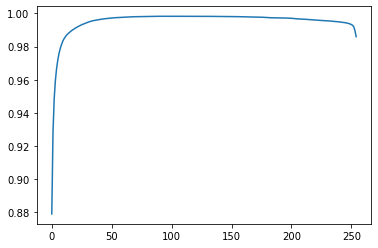

In [43]:
plt.plot(ixs, all_ratios)

In [44]:
filtered_ratios = [all_ratios[ix] for ix in ixs if ix >= 50 and ix <= 150]
filtered_ixs = [ix for ix in ixs if ix >= 50 and ix <= 150]

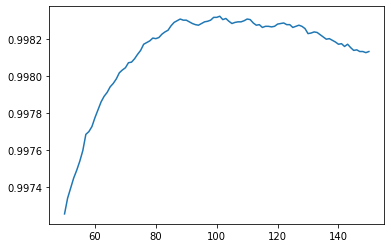

In [45]:
plt.plot(filtered_ixs, filtered_ratios)

In [46]:
np.argmax(all_ratios)

101

In [181]:
img = cv2.imread('c:/Users/ax/retina-unet-master-disc/test/all_predictions.png')
ret_val, img_out = cv2.threshold(img, 98, 255, cv2.THRESH_BINARY)
cv2.imwrite('c:/Users/ax/retina-unet-master-disc/test/all_predictions_bin.png', img_out) 

True

In [47]:
all_ratios[np.argmax(all_ratios)]

0.9983240392774881